In [12]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [13]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [14]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [15]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [16]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [17]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [18]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [ ]:
def build_1d_cnn_custom_ch_32_DO_BN(conv_num=1):
    kernel_size = 64
    filter_size = 32
    
    model=Sequential()
    model.add(Conv1D (kernel_size=3*kernel_size, filters=filter_size, strides=1, 
                      padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        target_kernel_size = 3 * (kernel_size//(2**(i+1)))
        model.add(Conv1D (kernel_size=target_kernel_size if target_kernel_size != 0 else 3, 
                          filters=filter_size*(2**int((i+1)/4)), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())    
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [ ]:
for i in range(3, 10):
    model = build_1d_cnn_custom_ch_32_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 32)         6176      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 32)         128       
_________________________________________________________________
activation (Activation)      (None, 16000, 32)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 32)         98336     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 16000, 32)         128       
_________________________________________________________________
activation_1 (Activat

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 16000, 32)         6176      
_________________________________________________________________
batch_normalization_v1_12 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_12 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 16000, 32)         98336     
_________________________________________________________________
batch_normalization_v1_13 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_13 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 5333, 32)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_33 (Conv1D)           (None, 16000, 32)         6176      
_________________________________________________________________
batch_normalization_v1_33 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_33 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 16000, 32)         98336     
_________________________________________________________________
batch_normalization_v1_34 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_34 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 5333, 32)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2231 - acc: 0.3293
Epoch 00001: val_loss improved from inf to 1.74101, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_32_DO_BN_3_conv_checkpoint/001-1.7410.hdf5
36805/36805 [==============================] - 81s 2ms/sample - loss: 2.2229 - acc: 0.3294 - val_loss: 1.7410 - val_acc: 0.4428
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4168 - acc: 0.5598
Epoch 00002: val_loss improved from 1.74101 to 1.52017, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_32_DO_BN_3_conv_checkpoint/002-1.5202.hdf5
36805/36805 [==============================] - 77s 2ms/sample - loss: 1.4168 - acc: 0.5597 - val_loss: 1.5202 - val_acc: 0.5274
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1906 - acc: 0.6314
Epoch 00003: val_loss improved from 1.52017

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0831 - acc: 0.9740
Epoch 00057: val_loss did not improve from 0.80211
36805/36805 [==============================] - 77s 2ms/sample - loss: 0.0833 - acc: 0.9739 - val_loss: 1.0406 - val_acc: 0.8076
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0927 - acc: 0.9724
Epoch 00058: val_loss did not improve from 0.80211
36805/36805 [==============================] - 77s 2ms/sample - loss: 0.0926 - acc: 0.9724 - val_loss: 1.0593 - val_acc: 0.7932
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0774 - acc: 0.9760
Epoch 00059: val_loss did not improve from 0.80211
36805/36805 [==============================] - 77s 2ms/sample - loss: 0.0774 - acc: 0.9760 - val_loss: 1.1815 - val_acc: 0.7808
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0740 - acc: 0.9774
Epoch 00060: val_loss did not improve from 0.80211
36805/36805 [===========

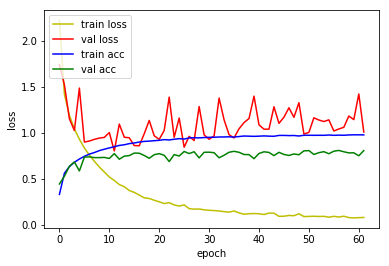

4815/4815 [==============================] - 4s 727us/sample - loss: 0.8692 - acc: 0.7506
Loss: 0.8692441447130245 Accuracy: 0.75057113

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2533 - acc: 0.3220
Epoch 00001: val_loss improved from inf to 1.47805, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_32_DO_BN_4_conv_checkpoint/001-1.4780.hdf5
36805/36805 [==============================] - 84s 2ms/sample - loss: 2.2533 - acc: 0.3220 - val_loss: 1.4780 - val_acc: 0.5183
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3859 - acc: 0.5664
Epoch 00002: val_loss improved from 1.47805 to 1.12839, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_32_DO_BN_4_conv_checkpoint/002-1.1284.hdf5
36805/36805 [==============================] - 81s 2ms/sample - loss: 1.3858 - acc: 0.5664 - val_loss: 1.1284 - val_acc: 0.6713
Epoch 3/500
36800/36805 [=========================

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1292 - acc: 0.9604
Epoch 00055: val_loss did not improve from 0.44988
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.1292 - acc: 0.9604 - val_loss: 0.6248 - val_acc: 0.8463
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1283 - acc: 0.9599
Epoch 00056: val_loss did not improve from 0.44988
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.1283 - acc: 0.9599 - val_loss: 0.7393 - val_acc: 0.8321
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1238 - acc: 0.9609
Epoch 00057: val_loss did not improve from 0.44988
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.1238 - acc: 0.9609 - val_loss: 0.5620 - val_acc: 0.8758
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1246 - acc: 0.9610
Epoch 00058: val_loss did not improve from 0.44988
36805/36805 [===========

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0759 - acc: 0.9761
Epoch 00085: val_loss did not improve from 0.44988
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.0759 - acc: 0.9761 - val_loss: 0.5659 - val_acc: 0.8877
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0762 - acc: 0.9755
Epoch 00086: val_loss did not improve from 0.44988
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.0762 - acc: 0.9754 - val_loss: 0.6548 - val_acc: 0.8710
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0874 - acc: 0.9723
Epoch 00087: val_loss did not improve from 0.44988
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.0874 - acc: 0.9723 - val_loss: 0.4902 - val_acc: 0.8940
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0770 - acc: 0.9760
Epoch 00088: val_loss did not improve from 0.44988
36805/36805 [===========

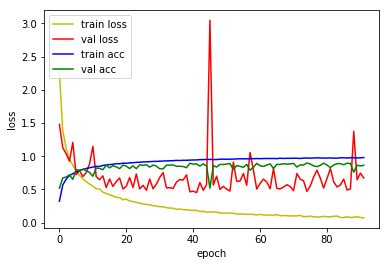

4815/4815 [==============================] - 4s 740us/sample - loss: 0.5532 - acc: 0.8424
Loss: 0.5531512016324116 Accuracy: 0.8423676

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2263 - acc: 0.3166
Epoch 00001: val_loss improved from inf to 1.46377, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_32_DO_BN_5_conv_checkpoint/001-1.4638.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 2.2262 - acc: 0.3166 - val_loss: 1.4638 - val_acc: 0.5271
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4200 - acc: 0.5439
Epoch 00002: val_loss improved from 1.46377 to 1.05125, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_32_DO_BN_5_conv_checkpoint/002-1.0512.hdf5
36805/36805 [==============================] - 84s 2ms/sample - loss: 1.4200 - acc: 0.5439 - val_loss: 1.0512 - val_acc: 0.6683
Epoch 3/500
36800/36805 [==========================

In [ ]:
for i in range(3, 10):
    base = '1D_CNN_custom_kernel_192_ch_32_DO_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_ch_32_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [19]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_kernel_192_ch_32_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_kernel_192_ch_32_DO_BN_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 32)         6176      
_________________________________________________________________
batch_normalization_v1_42 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_42 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 32)         98336     
_________________________________________________________________
batch_normalization_v1_43 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_43 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_35 (MaxPool

4815/4815 [==============================] - 5s 997us/sample - loss: 0.4510 - acc: 0.8856
Loss: 0.45099152171846985 Accuracy: 0.88556594

1D_CNN_custom_kernel_192_ch_32_DO_BN_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_54 (Conv1D)           (None, 16000, 32)         6176      
_________________________________________________________________
batch_normalization_v1_54 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_54 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 16000, 32)         98336     
_________________________________________________________________
batch_normalization_v1_55 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_55 (Activ

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2384 - acc: 0.9385
Loss: 0.23838554100091894 Accuracy: 0.93852544

1D_CNN_custom_kernel_192_ch_32_DO_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_67 (Conv1D)           (None, 16000, 32)         6176      
_________________________________________________________________
batch_normalization_v1_67 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_67 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 16000, 32)         98336     
_________________________________________________________________
batch_normalization_v1_68 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_68 (Activat

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.1922 - acc: 0.9398
Loss: 0.1922173076971731 Accuracy: 0.93977153
